In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip list | grep -e tqdm -e matplotlib -e seaborn -e torch -e numpy -e pandas

geopandas                        0.13.2
matplotlib                       3.7.1
matplotlib-inline                0.1.6
matplotlib-venn                  0.11.9
numpy                            1.23.5
pandas                           1.5.3
pandas-datareader                0.10.0
pandas-gbq                       0.17.9
seaborn                          0.12.2
sklearn-pandas                   2.2.0
torch                            2.0.1+cu118
torchaudio                       2.0.2+cu118
torchdata                        0.6.1
torchsummary                     1.5.1
torchtext                        0.15.2
torchvision                      0.15.2+cu118
tqdm                             4.66.1


In [ ]:
import copy
from glob import glob
import itertools
import math
import os
from pathlib import Path
import shutil
from typing import Callable, Literal, Optional, Type
import warnings

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
from torch.nn import functional as F
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid



In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 256  # 一辺のピクセル数
MAX_EPOCHS = 30  # 学習時の最大エポック数

# ImageNet統計に基づく正規化パラメータ
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

ALL_LABELS = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]
NUM_CLASSES = len(ALL_LABELS)
LABELS_TO_USE = ["bird", "cat", "deer", "dog", "horse", "monkey"]
LABELS_MAP = {
    i: LABELS_TO_USE.index(label)
    for i, label in enumerate(ALL_LABELS) if label in LABELS_TO_USE
}

ROOT_DIR_PATH = Path('/content/drive/MyDrive/ml-pg-book')
DIR_DATA = ROOT_DIR_PATH / "data"
DIR_DATA_UNKNOWN = DIR_DATA / "unknown"
DIR_MODELS = ROOT_DIR_PATH / "models"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


In [ ]:
os.makedirs(DIR_DATA, exist_ok=True)
os.makedirs(DIR_DATA_UNKNOWN, exist_ok=True)
os.makedirs(DIR_MODELS, exist_ok=True)

# Data Loaders Generation

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=IMAGE_SIZE, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

eval_transforms = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [ ]:
def create_STL10_dataloader(
    split: str,
    dir_to_save: Path = DIR_DATA,
    transform: Tensor = eval_transforms,
) -> DataLoader:
    dataset = datasets.STL10(
        root=dir_to_save,
        split=split,
        download=True,
        transform=transform,
    )

    if set(LABELS_TO_USE) != set(dataset.classes):
        indices_to_use = {
            dataset.classes.index(cat) for cat in LABELS_TO_USE
        }
        indices = [
            i for i, label in enumerate(dataset.labels)
            if label in indices_to_use
        ]
        dataset = Subset(dataset, indices)
        dataset.classes = ALL_LABELS

    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle= True,
        num_workers=os.cpu_count(),
    )


In [ ]:
# STL10用データローダの生成
dataloader_train = create_STL10_dataloader(
    split="train",
    transform=train_transforms,
)
dataloader_test = create_STL10_dataloader(
    split="test",
    transform=eval_transforms,
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def create_image_folder_dataloader(
    dir_to_load: Path,
    transform: Tensor = transforms.ToTensor(),
) -> DataLoader:
    for path in glob(f'{dir_to_load / "**" / ".ipynb_checkpoints"}', recursive=True):
        shutil.rmtree(path)

    dataset = datasets.ImageFolder(dir_to_load, transform=transform)

    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=os.cpu_count(),
    )


In [ ]:
# Image Folder用データローダの生成
dataloader_unknown = create_image_folder_dataloader(
    dir_to_load=DIR_DATA_UNKNOWN,
    transform=eval_transforms,
)

# Common Methods

In [ ]:
def destandardize(tensor: Tensor):
    for t, m, s in zip(tensor, IMAGENET_MEAN, IMAGENET_STD):
        t.mul_(s).add_(m)
    return tensor

# Visualization

In [ ]:
def show_images_of_first_batch(dataloader: DataLoader):
    torch.manual_seed(0)
    X, y = next(iter(dataloader))
    nrow = 4
    plt.figure(figsize=(
        2 * nrow,
        2 * math.ceil(BATCH_SIZE / nrow)
    ))
    plt.imshow(
        make_grid(
            [destandardize(x) for x in X],
            nrow=nrow, padding=8, pad_value=1
        ).permute(1, 2, 0)
    )


In [ ]:
dataloader_for_display = create_STL10_dataloader(
    split="train",
)


Files already downloaded and verified


In [ ]:
show_images_of_first_batch(dataloader_for_display)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_images_of_first_batch(dataloader_train)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_images_of_first_batch(dataloader_test)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def show_raw_images_of_first_batch(dataloader: DataLoader):
    torch.manual_seed(0)
    images, labels = next(iter(dataloader))
    print("Shape of X [N, C, H, W]: ", images.shape)
    print(images[0])
    print("Shape of y: ", labels.shape, labels.dtype)
    print(labels)


In [ ]:
show_raw_images_of_first_batch(dataloader_for_display)

Shape of X [N, C, H, W]:  torch.Size([64, 3, 256, 256])
tensor([[[-0.2513, -0.2513, -0.2513,  ..., -0.3369, -0.3369, -0.3369],
         [-0.2513, -0.2513, -0.2513,  ..., -0.3369, -0.3369, -0.3369],
         [-0.2513, -0.2513, -0.2513,  ..., -0.3369, -0.3369, -0.3369],
         ...,
         [-0.2856, -0.2856, -0.2856,  ..., -0.4226, -0.4226, -0.4226],
         [-0.2856, -0.2856, -0.2856,  ..., -0.4226, -0.4226, -0.4226],
         [-0.2856, -0.2856, -0.2856,  ..., -0.4226, -0.4226, -0.4226]],

        [[ 0.0476,  0.0476,  0.0476,  ..., -0.0924, -0.0924, -0.0924],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.0924, -0.0924, -0.0924],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.0924, -0.0924, -0.0924],
         ...,
         [-0.0399, -0.0399, -0.0399,  ..., -0.1800, -0.1800, -0.1800],
         [-0.0399, -0.0399, -0.0399,  ..., -0.1800, -0.1800, -0.1800],
         [-0.0399, -0.0399, -0.0399,  ..., -0.1800, -0.1800, -0.1800]],

        [[ 0.7402,  0.7402,  0.7402,  ...,  0.5834,  0.5834,

In [ ]:
def plot_accuracy(accuracy: dict[str, list[float]], title: Optional[str] = None):
    sns.lineplot(accuracy)
    plt.xlabel(f"epochs")
    plt.ylabel(f"accuracy")
    if title is not None:
        plt.title(title)

# Model Wrapper Class

In [ ]:
# 連続何回エポック更新がされないときに学習を打ち切るか
early_stopped_not_updated_times = 5

class NeuralNetworkModelWrapper:
    def __init__(
        self, model_class: Type[nn.Module],
        model_file_name: str,
        extra_func: Optional[Callable] = None,
    ):
        self.model_class = model_class
        self.extra_func = extra_func
        self.model = self._initialize_model()

        self.model_file_name = model_file_name
        self.acc_train = []
        self.acc_test = []
        self.acc_test_best = None

    def _initialize_model(self):
        model = self.model_class()
        if self.extra_func is not None:
            model = self.extra_func(model)
        model = model.to(DEVICE)
        print(model)
        return model

    def _epoch_iteration(
        self, dataloader: DataLoader, loss_fn,
        phase: Literal["train", "test"], dataset_type: str,
        optimizer=None,
        num_batches_for_test: int = 20,
    ):
        if phase == "train":
            self.model.train()
        elif phase == "test":
            self.model.eval()
        else:
            raise RuntimeError('phase should be either of "train" or "test')

        loss_sum, correct_sum, num_images = 0, 0, 0

        if phase == "train":
            num_batches = len(dataloader)
        else:
            num_batches = num_batches_for_test

        with torch.set_grad_enabled(phase=="train"), \
                tqdm(total=num_batches, unit="batch") as pbar:
            desc = f"{phase} with {dataset_type} dataset"
            pbar.set_description(f"{desc:27s}")
            for batch_i, (X, y) in enumerate(dataloader):
                if phase == "test" and batch_i == num_batches_for_test:
                    break

                X, y = X.to(DEVICE), y.to(DEVICE)

                # 損失を計算
                pred = self.model(X)
                loss = loss_fn(pred, y)

                # 誤差逆伝播
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # 損失・正解数を加算
                loss_sum += loss.item()
                correct_sum += (pred.argmax(1) == y).type(torch.float).sum().item()

                num_images += len(X)

                pbar.set_postfix({
                    "loss": f"{loss_sum / (batch_i + 1):>6.3f}",
                    "accuracy": f"{100 * correct_sum / num_images:>5.1f}%"
                })
                pbar.update(1)

        accuracy = correct_sum / num_images
        return accuracy

    def learn(
        self, max_epochs: int,
        dataloader_train: DataLoader,
        dataloader_test: DataLoader,
        loss_fn = None, optimizer = None,
        seed: int = 0,
        save: bool = True,
    ):
        if loss_fn is None:
            loss_fn = nn.CrossEntropyLoss()
        if optimizer is None:
            optimizer = torch.optim.SGD(
                self.model.parameters(), lr=1e-3, momentum=0.9
            )
        torch.manual_seed(seed)
        acc_train = []
        acc_test = []
        self.acc_test_best = 0.0
        best_model_weights = copy.deepcopy(self.model.state_dict())
        num_not_updated = 0
        for t in range(max_epochs + 1):
            print(f"Epoch {t}\n-------------------------------")
            if t != 0:
                self._epoch_iteration(
                    dataloader_train, loss_fn, phase="train",
                    dataset_type="training", optimizer=optimizer
                )
            _acc_train = self._epoch_iteration(
                dataloader_train, loss_fn, phase="test",
                dataset_type="training"
            )
            acc_train.append(_acc_train)
            _acc_test = self._epoch_iteration(
                dataloader_test, loss_fn, phase="test",
                dataset_type="testing"
            )
            acc_test.append(_acc_test)

            if _acc_test > self.acc_test_best:
                best_model_weights = copy.deepcopy(self.model.state_dict())
                print(
                    "Best test accuracy has been updated "
                    f"({100 * self.acc_test_best:>5.1f}% -> {100 * _acc_test:>5.1f}%)"
                )
                self.acc_test_best = _acc_test
                num_not_updated = 0
            else:
                print("Best test accuracy has not been updated "
                      f"({100 * self.acc_test_best:>5.1f}%)"
                )
                num_not_updated += 1
                if num_not_updated == early_stopped_not_updated_times:
                    print(
                        "Stopped because the best test accuracy "
                        "has not been updated for 5 epochs in a row."
                    )
                    break

            print()
        self.model.load_state_dict(best_model_weights)
        self.acc_train = acc_train
        self.acc_test = acc_test
        print("Done!")

        if save:
            self.save()

    def save(self):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "eval_results": {
                    "acc_train": self.acc_train,
                    "acc_test": self.acc_test,
                    "acc_test_best": self.acc_test_best,
                }
            },
            DIR_MODELS / self.model_file_name
        )
        print("Saved")

    def load(self):
        path = DIR_MODELS / self.model_file_name
        if os.path.exists(path):
            artifacts = torch.load(
                DIR_MODELS / self.model_file_name,
                map_location=DEVICE,
            )
            self.model.load_state_dict(
                artifacts["model_state_dict"]
            )
            self.acc_train = artifacts["eval_results"]["acc_train"]
            self.acc_test = artifacts["eval_results"]["acc_test"]
            self.acc_test_best = artifacts["eval_results"]["acc_test_best"]
            print("Loaded")
            return True
        else:
            print(f"{path} does not exist")
            return False

    def predict(
        self,
        dataloader: DataLoader,
        num_batches = None,
        seed: int = 0
    ) -> pd.DataFrame:
        torch.manual_seed(seed)
        self.model.eval()
        correct1 = 0
        correct3 = 0
        for i, (X, y) in enumerate(dataloader):
            if i == num_batches:
                break

            X, y = X.to(DEVICE), y.to(DEVICE)
            with torch.no_grad():
                scores = F.softmax(self.model(X), dim=1)
                predicted_labels = torch.argsort(scores, dim=1, descending=True)

            for j in range(len(y)):
                actual_label = dataloader.dataset.classes[y[j]]

                plt.figure(figsize=(3.2, 2.4))
                plt.imshow(destandardize(X[j]).cpu().permute(1, 2, 0))
                plt.title(actual_label)
                plt.show()

                add_correct3 = False
                for k in range(3):
                    label_index = predicted_labels[j, k]
                    label = LABELS_TO_USE[LABELS_MAP[int(label_index)]]
                    add_correct3 |= actual_label == label
                    correct1 += 1 if k == 0 and actual_label == label else 0
                    print(
                        f"{label:<10s}: "
                        f"{100 * scores[j, label_index]:5.1f}%"
                    )
                correct3 += add_correct3
                print()

        has_actual_labels = len(
            set(dataloader.dataset.classes) &
            set(LABELS_TO_USE)
        ) > 0

        if has_actual_labels:
            print(f"Acc@1 = {correct1/len(y):.1%} ({correct1}/{len(y)})")
            print(f"Acc@3 = {correct3/len(y):.1%} ({correct3}/{len(y)})")

    def load_and_predict(self, dataloader: DataLoader):
        self.load()
        self.predict(dataloader)


# FCNN

## Learning

In [ ]:
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

class FullyConnectedNeuralNetwork(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        layer_width = 1024
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * IMAGE_SIZE * IMAGE_SIZE, layer_width),
            nn.BatchNorm1d(layer_width),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(layer_width, layer_width),
            nn.BatchNorm1d(layer_width),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(layer_width, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [ ]:
fcnn = NeuralNetworkModelWrapper(FullyConnectedNeuralNetwork, "fcnn.pth")

FullyConnectedNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=196608, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [ ]:
# fcnn.learn(
#     max_epochs=MAX_EPOCHS,
#     dataloader_train=dataloader_train,
#     dataloader_test=dataloader_test,
# )

Epoch 0
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.57batch/s, loss=2.322, accuracy=6.2%]


Best test accuracy has been updated (  0.0% ->   6.2%)

Epoch 1
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.34batch/s, loss=1.737, accuracy=31.8%]


Best test accuracy has been updated (  6.2% ->  31.8%)

Epoch 2
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.72batch/s, loss=1.701, accuracy=32.9%]


Best test accuracy has been updated ( 31.8% ->  32.9%)

Epoch 3
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.58batch/s, loss=1.636, accuracy=35.7%]


Best test accuracy has been updated ( 32.9% ->  35.7%)

Epoch 4
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.68batch/s, loss=1.619, accuracy=37.1%]


Best test accuracy has been updated ( 35.7% ->  37.1%)

Epoch 5
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.17batch/s, loss=1.611, accuracy=35.9%]


Best test accuracy has not been updated ( 37.1%)

Epoch 6
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.57batch/s, loss=1.609, accuracy=35.2%]


Best test accuracy has not been updated ( 37.1%)

Epoch 7
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.46batch/s, loss=1.604, accuracy=35.3%]


Best test accuracy has not been updated ( 37.1%)

Epoch 8
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.74batch/s, loss=1.559, accuracy=37.9%]


Best test accuracy has been updated ( 37.1% ->  37.9%)

Epoch 9
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.52batch/s, loss=1.579, accuracy=35.9%]


Best test accuracy has not been updated ( 37.9%)

Epoch 10
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.79batch/s, loss=1.567, accuracy=36.5%]


Best test accuracy has not been updated ( 37.9%)

Epoch 11
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.08batch/s, loss=1.555, accuracy=39.1%]


Best test accuracy has been updated ( 37.9% ->  39.1%)

Epoch 12
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.81batch/s, loss=1.553, accuracy=38.0%]


Best test accuracy has not been updated ( 39.1%)

Epoch 13
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.60batch/s, loss=1.540, accuracy=38.9%]


Best test accuracy has not been updated ( 39.1%)

Epoch 14
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.49batch/s, loss=1.550, accuracy=38.4%]


Best test accuracy has not been updated ( 39.1%)

Epoch 15
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.79batch/s, loss=1.548, accuracy=38.0%]


Best test accuracy has not been updated ( 39.1%)

Epoch 16
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.81batch/s, loss=1.503, accuracy=40.1%]


Best test accuracy has been updated ( 39.1% ->  40.1%)

Epoch 17
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.45batch/s, loss=1.507, accuracy=40.1%]


Best test accuracy has not been updated ( 40.1%)

Epoch 18
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.58batch/s, loss=1.526, accuracy=39.4%]


Best test accuracy has not been updated ( 40.1%)

Epoch 19
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.12batch/s, loss=1.537, accuracy=38.7%]


Best test accuracy has not been updated ( 40.1%)

Epoch 20
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.68batch/s, loss=1.523, accuracy=40.6%]


Best test accuracy has been updated ( 40.1% ->  40.6%)

Epoch 21
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.80batch/s, loss=1.443, accuracy=42.3%]


Best test accuracy has been updated ( 40.6% ->  42.3%)

Epoch 22
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.66batch/s, loss=1.495, accuracy=41.6%]


Best test accuracy has not been updated ( 42.3%)

Epoch 23
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.93batch/s, loss=1.494, accuracy=42.5%]


Best test accuracy has been updated ( 42.3% ->  42.5%)

Epoch 24
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.91batch/s, loss=1.521, accuracy=39.1%]


Best test accuracy has not been updated ( 42.5%)

Epoch 25
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.53batch/s, loss=1.493, accuracy=41.8%]


Best test accuracy has not been updated ( 42.5%)

Epoch 26
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.65batch/s, loss=1.498, accuracy=40.5%]


Best test accuracy has not been updated ( 42.5%)

Epoch 27
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.86batch/s, loss=1.524, accuracy=39.0%]


Best test accuracy has not been updated ( 42.5%)

Epoch 28
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.72batch/s, loss=1.492, accuracy=40.8%]


Best test accuracy has not been updated ( 42.5%)
Stopped because the best test accuracy has not been updated for 5 epochs in a row.
Done!
Saved


In [ ]:
loaded = fcnn.load()
if not loaded:
    fcnn.learn(
        max_epochs=MAX_EPOCHS,
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
    )

Loaded


## Prediction & Evaluation

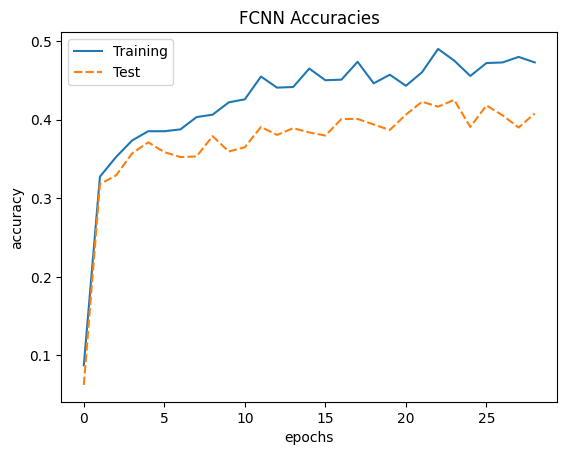

In [ ]:
plot_accuracy({
    "Training": fcnn.acc_train,
    "Test": fcnn.acc_test,
}, title="FCNN Accuracies")

In [ ]:
fcnn.predict(dataloader_test, num_batches=1)

Output hidden; open in https://colab.research.google.com to view.

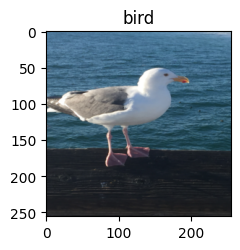

bird      :  34.1%
deer      :  22.3%
monkey    :  15.6%



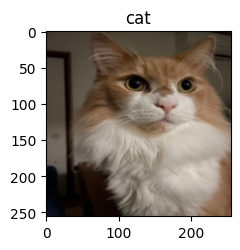

cat       :  56.0%
dog       :  25.4%
monkey    :   7.9%



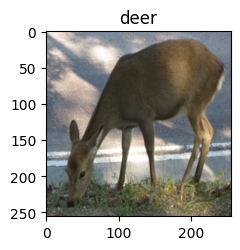

horse     :  51.7%
dog       :  16.9%
monkey    :  12.7%



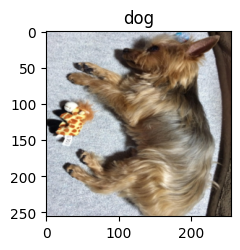

dog       :  32.1%
bird      :  27.7%
cat       :  12.6%



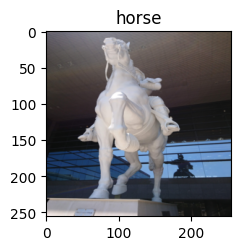

bird      :  53.5%
dog       :  18.0%
monkey    :  16.5%

Acc@1 = 60.0% (3/5)
Acc@3 = 60.0% (3/5)


In [ ]:
fcnn.predict(dataloader_unknown)

# CNN

## Learning

In [ ]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        fc_size = 4096
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(
                256 * 7 * 7, fc_size
            ),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(fc_size, fc_size),
            nn.ReLU(inplace=True),
            nn.Linear(fc_size, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
cnn = NeuralNetworkModelWrapper(ConvolutionalNeuralNetwork, "cnn.pth")

ConvolutionalNeuralNetwork(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=Tru

In [ ]:
cnn.learn(
    max_epochs=MAX_EPOCHS,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    save=False
)

Epoch 0
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.39batch/s, loss=2.300, accuracy=16.6%]


Best test accuracy has been updated (  0.0% ->  16.6%)

Epoch 1
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.49batch/s, loss=1.686, accuracy=32.7%]


Best test accuracy has been updated ( 16.6% ->  32.7%)

Epoch 2
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.62batch/s, loss=1.582, accuracy=37.6%]


Best test accuracy has been updated ( 32.7% ->  37.6%)

Epoch 3
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.48batch/s, loss=1.521, accuracy=37.6%]


Best test accuracy has not been updated ( 37.6%)

Epoch 4
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.54batch/s, loss=1.383, accuracy=48.4%]


Best test accuracy has been updated ( 37.6% ->  48.4%)

Epoch 5
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.29batch/s, loss=1.332, accuracy=47.5%]


Best test accuracy has not been updated ( 48.4%)

Epoch 6
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.13batch/s, loss=1.267, accuracy=51.7%]


Best test accuracy has been updated ( 48.4% ->  51.7%)

Epoch 7
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.24batch/s, loss=1.248, accuracy=54.1%]


Best test accuracy has been updated ( 51.7% ->  54.1%)

Epoch 8
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.18batch/s, loss=1.360, accuracy=50.6%]


Best test accuracy has not been updated ( 54.1%)

Epoch 9
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.80batch/s, loss=1.291, accuracy=49.8%]


Best test accuracy has not been updated ( 54.1%)

Epoch 10
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.25batch/s, loss=1.167, accuracy=56.7%]


Best test accuracy has been updated ( 54.1% ->  56.7%)

Epoch 11
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.45batch/s, loss=1.351, accuracy=50.0%]


Best test accuracy has not been updated ( 56.7%)

Epoch 12
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.98batch/s, loss=1.228, accuracy=56.0%]


Best test accuracy has not been updated ( 56.7%)

Epoch 13
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.18batch/s, loss=1.194, accuracy=57.8%]


Best test accuracy has been updated ( 56.7% ->  57.8%)

Epoch 14
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.29batch/s, loss=1.551, accuracy=47.6%]


Best test accuracy has not been updated ( 57.8%)

Epoch 15
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.43batch/s, loss=1.210, accuracy=58.3%]


Best test accuracy has been updated ( 57.8% ->  58.3%)

Epoch 16
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.17batch/s, loss=1.194, accuracy=55.8%]


Best test accuracy has not been updated ( 58.3%)

Epoch 17
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.30batch/s, loss=1.349, accuracy=53.9%]


Best test accuracy has not been updated ( 58.3%)

Epoch 18
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.26batch/s, loss=1.079, accuracy=60.8%]


Best test accuracy has been updated ( 58.3% ->  60.8%)

Epoch 19
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.31batch/s, loss=1.181, accuracy=59.6%]


Best test accuracy has not been updated ( 60.8%)

Epoch 20
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.66batch/s, loss=1.252, accuracy=56.7%]


Best test accuracy has not been updated ( 60.8%)

Epoch 21
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.45batch/s, loss=1.121, accuracy=61.6%]


Best test accuracy has been updated ( 60.8% ->  61.6%)

Epoch 22
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.30batch/s, loss=1.203, accuracy=58.0%]


Best test accuracy has not been updated ( 61.6%)

Epoch 23
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.10batch/s, loss=1.043, accuracy=64.2%]


Best test accuracy has been updated ( 61.6% ->  64.2%)

Epoch 24
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.78batch/s, loss=1.099, accuracy=64.5%]


Best test accuracy has been updated ( 64.2% ->  64.5%)

Epoch 25
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.25batch/s, loss=1.106, accuracy=62.2%]


Best test accuracy has not been updated ( 64.5%)

Epoch 26
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.48batch/s, loss=1.228, accuracy=59.5%]


Best test accuracy has not been updated ( 64.5%)

Epoch 27
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.49batch/s, loss=1.070, accuracy=62.1%]


Best test accuracy has not been updated ( 64.5%)

Epoch 28
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.45batch/s, loss=1.071, accuracy=62.8%]


Best test accuracy has not been updated ( 64.5%)

Epoch 29
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.28batch/s, loss=1.099, accuracy=64.1%]

Best test accuracy has not been updated ( 64.5%)
Stopped because the best test accuracy has not been updated for 5 epochs in a row.
Done!


In [ ]:
loaded = cnn.load()
if not loaded:
    cnn.learn(
        max_epochs=MAX_EPOCHS,
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
    )

Loaded


## Prediction & Evaluation

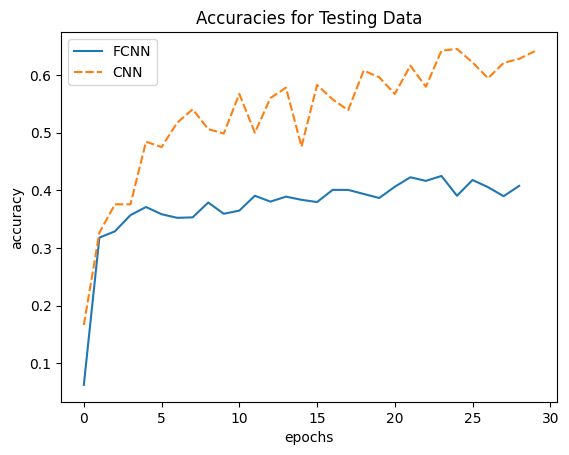

In [ ]:
plot_accuracy({
    "FCNN": fcnn.acc_test,
    "CNN": cnn.acc_test
}, title="Accuracies for Testing Data")

In [ ]:
cnn.predict(dataloader_test, num_batches=1)

Output hidden; open in https://colab.research.google.com to view.

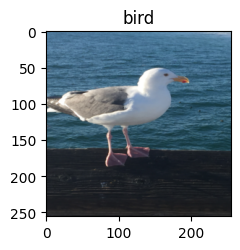

horse     :  47.2%
bird      :  44.6%
deer      :   6.9%



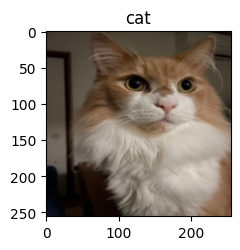

cat       :  46.4%
dog       :  27.2%
bird      :  20.1%



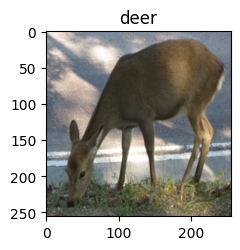

horse     :  79.0%
deer      :  10.2%
monkey    :   5.4%



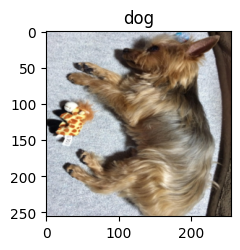

bird      :  59.6%
monkey    :  16.5%
cat       :  13.1%



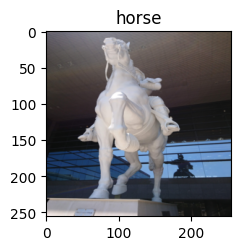

bird      :  81.8%
horse     :  13.5%
dog       :   3.4%

Acc@1 = 20.0% (1/5)
Acc@3 = 80.0% (4/5)


In [ ]:
cnn.predict(dataloader_unknown)

# ResNet18

## Learning

In [ ]:
def change_fc(model):
    model.fc = torch.nn.Linear(
        in_features=model.fc.in_features,
        out_features=len(ALL_LABELS)
    ).to(DEVICE)
    return model

In [ ]:
resnet18 = NeuralNetworkModelWrapper(
    model_class=models.resnet18,
    model_file_name="resnet18.pth",
    extra_func=change_fc,
)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# resnet18.learn(
#     max_epochs=MAX_EPOCHS,
#     dataloader_train=dataloader_train,
#     dataloader_test=dataloader_test,
# )

Epoch 0
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.55batch/s, loss=2.992, accuracy=0.0%]


Best test accuracy has not been updated (  0.0%)

Epoch 1
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.12batch/s, loss=1.731, accuracy=25.5%]


Best test accuracy has been updated (  0.0% ->  25.5%)

Epoch 2
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.69batch/s, loss=1.684, accuracy=31.4%]


Best test accuracy has been updated ( 25.5% ->  31.4%)

Epoch 3
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.07batch/s, loss=1.660, accuracy=32.0%]


Best test accuracy has been updated ( 31.4% ->  32.0%)

Epoch 4
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.12batch/s, loss=1.624, accuracy=35.8%]


Best test accuracy has been updated ( 32.0% ->  35.8%)

Epoch 5
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.55batch/s, loss=1.608, accuracy=35.1%]


Best test accuracy has not been updated ( 35.8%)

Epoch 6
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.19batch/s, loss=1.570, accuracy=37.9%]


Best test accuracy has been updated ( 35.8% ->  37.9%)

Epoch 7
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.93batch/s, loss=1.578, accuracy=37.1%]


Best test accuracy has not been updated ( 37.9%)

Epoch 8
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.08batch/s, loss=1.583, accuracy=37.1%]


Best test accuracy has not been updated ( 37.9%)

Epoch 9
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.15batch/s, loss=1.542, accuracy=37.5%]


Best test accuracy has not been updated ( 37.9%)

Epoch 10
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.46batch/s, loss=1.486, accuracy=42.3%]


Best test accuracy has been updated ( 37.9% ->  42.3%)

Epoch 11
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.16batch/s, loss=1.531, accuracy=37.8%]


Best test accuracy has not been updated ( 42.3%)

Epoch 12
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.19batch/s, loss=1.466, accuracy=42.4%]


Best test accuracy has been updated ( 42.3% ->  42.4%)

Epoch 13
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.08batch/s, loss=1.436, accuracy=43.9%]


Best test accuracy has been updated ( 42.4% ->  43.9%)

Epoch 14
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.18batch/s, loss=1.463, accuracy=45.4%]


Best test accuracy has been updated ( 43.9% ->  45.4%)

Epoch 15
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.48batch/s, loss=1.359, accuracy=48.3%]


Best test accuracy has been updated ( 45.4% ->  48.3%)

Epoch 16
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.19batch/s, loss=1.374, accuracy=49.5%]


Best test accuracy has been updated ( 48.3% ->  49.5%)

Epoch 17
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.48batch/s, loss=1.412, accuracy=46.9%]


Best test accuracy has not been updated ( 49.5%)

Epoch 18
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.56batch/s, loss=1.362, accuracy=47.5%]


Best test accuracy has not been updated ( 49.5%)

Epoch 19
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.80batch/s, loss=1.524, accuracy=46.7%]


Best test accuracy has not been updated ( 49.5%)

Epoch 20
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.59batch/s, loss=1.434, accuracy=46.9%]


Best test accuracy has not been updated ( 49.5%)

Epoch 21
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.97batch/s, loss=1.348, accuracy=49.6%]


Best test accuracy has been updated ( 49.5% ->  49.6%)

Epoch 22
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.01batch/s, loss=1.263, accuracy=52.3%]


Best test accuracy has been updated ( 49.6% ->  52.3%)

Epoch 23
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.49batch/s, loss=1.327, accuracy=51.4%]


Best test accuracy has not been updated ( 52.3%)

Epoch 24
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.88batch/s, loss=1.263, accuracy=53.0%]


Best test accuracy has been updated ( 52.3% ->  53.0%)

Epoch 25
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.37batch/s, loss=1.262, accuracy=54.1%]


Best test accuracy has been updated ( 53.0% ->  54.1%)

Epoch 26
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.22batch/s, loss=1.276, accuracy=50.4%]


Best test accuracy has not been updated ( 54.1%)

Epoch 27
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.02batch/s, loss=1.357, accuracy=48.2%]


Best test accuracy has not been updated ( 54.1%)

Epoch 28
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.78batch/s, loss=1.332, accuracy=52.5%]


Best test accuracy has not been updated ( 54.1%)

Epoch 29
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.16batch/s, loss=1.398, accuracy=49.9%]


Best test accuracy has not been updated ( 54.1%)

Epoch 30
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.43batch/s, loss=1.375, accuracy=50.7%]


Best test accuracy has not been updated ( 54.1%)
Stopped because the best test accuracy has not been updated for 5 epochs in a row.
Done!
Saved


In [ ]:
loaded = resnet18.load()
if not loaded:
    resnet18.learn(
        max_epochs=MAX_EPOCHS,
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
    )

Loaded


## Prediction & Evaluation

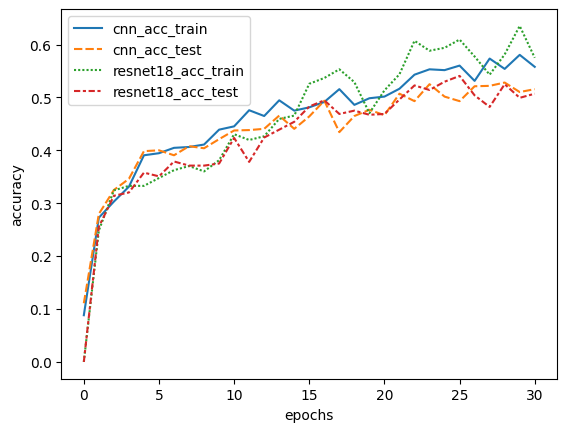

In [ ]:
plot_accuracy({
    "cnn_acc_train": cnn.acc_train,
    "cnn_acc_test": cnn.acc_test,
    "resnet18_acc_train": resnet18.acc_train,
    "resnet18_acc_test": resnet18.acc_test
})

In [ ]:
resnet18.predict(dataloader_test, num_batches=1)

Output hidden; open in https://colab.research.google.com to view.

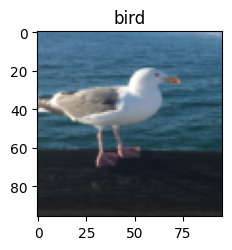

bird      :  44.1%
deer      :  18.5%
horse     :  13.9%



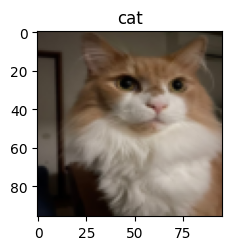

cat       :  33.7%
monkey    :  25.5%
dog       :  19.8%



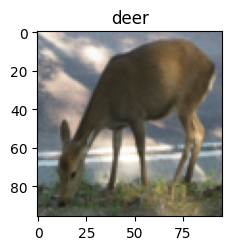

horse     :  56.1%
dog       :  22.9%
monkey    :  12.6%



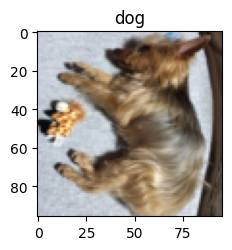

monkey    :  39.7%
dog       :  23.7%
cat       :  21.1%



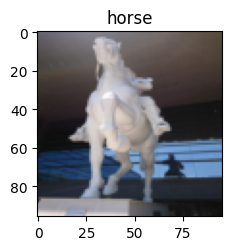

monkey    :  38.5%
bird      :  25.9%
dog       :  17.7%

Acc@1 = 40.0% (2/5)
Acc@3 = 60.0% (3/5)


In [ ]:
resnet18.predict(dataloader_unknown)

# Transfer Learning from Pre-trained ResNet18

## Learning

In [ ]:
def change_model(model):
    model = torch.hub.load(
        "pytorch/vision", "resnet18", weights="IMAGENET1K_V1"
    ).to(DEVICE)
    for name, param in model.named_parameters():
        param.requires_grad = False
    model = change_fc(model).to(DEVICE)
    return model

resnet18_pretrained = NeuralNetworkModelWrapper(
    model_class=models.resnet18,
    model_file_name="resnet18_pretrained.pth",
    extra_func=change_model,
)



Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# resnet18_pretrained.learn(
#     max_epochs=MAX_EPOCHS,
#     dataloader_train=dataloader_train,
#     dataloader_test=dataloader_test,
# )

Epoch 0
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.42batch/s, loss=2.450, accuracy=7.2%]


Best test accuracy has been updated (  0.0% ->   7.2%)

Epoch 1
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.98batch/s, loss=0.814, accuracy=82.6%]


Best test accuracy has been updated (  7.2% ->  82.6%)

Epoch 2
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.07batch/s, loss=0.538, accuracy=87.6%]


Best test accuracy has been updated ( 82.6% ->  87.6%)

Epoch 3
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.54batch/s, loss=0.449, accuracy=88.7%]


Best test accuracy has been updated ( 87.6% ->  88.7%)

Epoch 4
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.05batch/s, loss=0.384, accuracy=90.9%]


Best test accuracy has been updated ( 88.7% ->  90.9%)

Epoch 5
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.16batch/s, loss=0.361, accuracy=91.3%]


Best test accuracy has been updated ( 90.9% ->  91.3%)

Epoch 6
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.63batch/s, loss=0.330, accuracy=90.9%]


Best test accuracy has not been updated ( 91.3%)

Epoch 7
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.56batch/s, loss=0.320, accuracy=91.4%]


Best test accuracy has been updated ( 91.3% ->  91.4%)

Epoch 8
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.83batch/s, loss=0.300, accuracy=92.0%]


Best test accuracy has been updated ( 91.4% ->  92.0%)

Epoch 9
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.51batch/s, loss=0.315, accuracy=90.5%]


Best test accuracy has not been updated ( 92.0%)

Epoch 10
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.91batch/s, loss=0.278, accuracy=91.9%]


Best test accuracy has not been updated ( 92.0%)

Epoch 11
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.85batch/s, loss=0.287, accuracy=92.0%]


Best test accuracy has not been updated ( 92.0%)

Epoch 12
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.44batch/s, loss=0.294, accuracy=89.8%]


Best test accuracy has not been updated ( 92.0%)

Epoch 13
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.13batch/s, loss=0.277, accuracy=92.0%]


Best test accuracy has been updated ( 92.0% ->  92.0%)

Epoch 14
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.97batch/s, loss=0.282, accuracy=91.6%]


Best test accuracy has not been updated ( 92.0%)

Epoch 15
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.78batch/s, loss=0.248, accuracy=92.6%]


Best test accuracy has been updated ( 92.0% ->  92.6%)

Epoch 16
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.72batch/s, loss=0.270, accuracy=92.0%]


Best test accuracy has not been updated ( 92.6%)

Epoch 17
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.87batch/s, loss=0.270, accuracy=91.7%]


Best test accuracy has not been updated ( 92.6%)

Epoch 18
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.51batch/s, loss=0.249, accuracy=92.7%]


Best test accuracy has been updated ( 92.6% ->  92.7%)

Epoch 19
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.89batch/s, loss=0.257, accuracy=91.8%]


Best test accuracy has not been updated ( 92.7%)

Epoch 20
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.69batch/s, loss=0.257, accuracy=92.2%]


Best test accuracy has not been updated ( 92.7%)

Epoch 21
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.55batch/s, loss=0.223, accuracy=93.8%]


Best test accuracy has been updated ( 92.7% ->  93.8%)

Epoch 22
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.96batch/s, loss=0.244, accuracy=92.3%]


Best test accuracy has not been updated ( 93.8%)

Epoch 23
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.50batch/s, loss=0.253, accuracy=91.7%]


Best test accuracy has not been updated ( 93.8%)

Epoch 24
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.09batch/s, loss=0.250, accuracy=92.1%]


Best test accuracy has not been updated ( 93.8%)

Epoch 25
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.85batch/s, loss=0.239, accuracy=92.0%]


Best test accuracy has not been updated ( 93.8%)

Epoch 26
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.04batch/s, loss=0.233, accuracy=92.7%]


Best test accuracy has not been updated ( 93.8%)
Stopped because the best test accuracy has not been updated for 5 epochs in a row.
Done!
Saved


In [ ]:
loaded = resnet18_pretrained.load()
if not loaded:
    resnet18_pretrained.learn(
        max_epochs=MAX_EPOCHS,
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
    )

Loaded


## Prediction & Evaluation

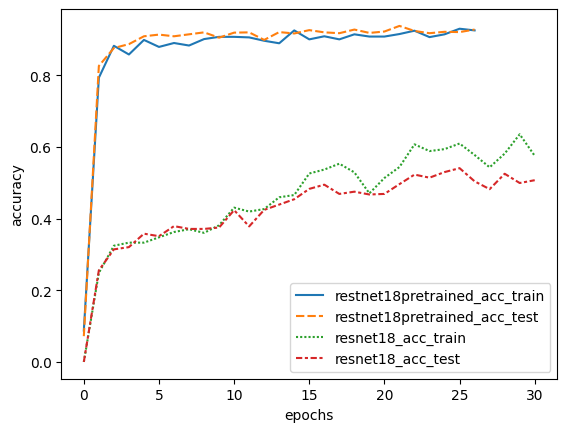

In [ ]:
plot_accuracy({
    "restnet18pretrained_acc_train": resnet18_pretrained.acc_train,
    "restnet18pretrained_acc_test": resnet18_pretrained.acc_test,
    "resnet18_acc_train": resnet18.acc_train,
    "resnet18_acc_test": resnet18.acc_test
})

In [ ]:
resnet18_pretrained.predict(dataloader_test, num_batches=1)

Output hidden; open in https://colab.research.google.com to view.

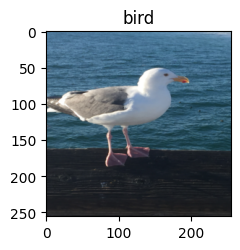

bird      :  88.5%
dog       :   9.4%
deer      :   1.0%



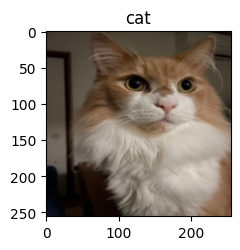

cat       :  98.5%
bird      :   0.8%
monkey    :   0.4%



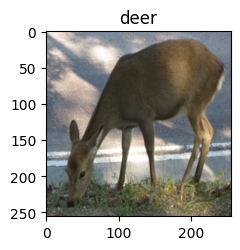

deer      :  99.4%
cat       :   0.4%
bird      :   0.1%



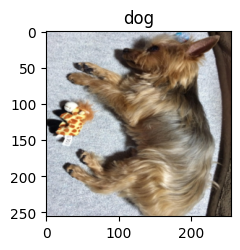

dog       :  35.7%
monkey    :  26.6%
cat       :  16.0%



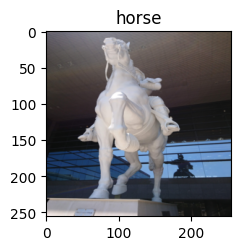

cat       :  37.4%
dog       :  36.4%
horse     :  12.5%

Acc@1 = 80.0% (4/5)
Acc@3 = 100.0% (5/5)


In [ ]:
resnet18_pretrained.predict(dataloader_unknown)

# AlexNet

## Learning

In [ ]:
def change_classifier(model):
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(
        in_features=in_features,
        out_features=len(ALL_LABELS)
    ).to(DEVICE)
    return model

alexnet = NeuralNetworkModelWrapper(
    model_class=models.alexnet,
    model_file_name="alexnet.pth",
    extra_func=change_classifier,
)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alexnet.learn(
    max_epochs=MAX_EPOCHS,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
)

Epoch 0
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.27batch/s, loss=2.300, accuracy=16.3%]


Best test accuracy has been updated (  0.0% ->  16.3%)

Epoch 1
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.50batch/s, loss=2.256, accuracy=16.8%]


Best test accuracy has been updated ( 16.3% ->  16.8%)

Epoch 2
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.16batch/s, loss=2.140, accuracy=17.1%]


Best test accuracy has been updated ( 16.8% ->  17.1%)

Epoch 3
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:08<00:00,  2.47batch/s, loss=1.811, accuracy=16.6%]


Best test accuracy has not been updated ( 17.1%)

Epoch 4
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.33batch/s, loss=1.799, accuracy=16.6%]


Best test accuracy has not been updated ( 17.1%)

Epoch 5
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.59batch/s, loss=1.802, accuracy=18.3%]


Best test accuracy has been updated ( 17.1% ->  18.3%)

Epoch 6
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:07<00:00,  2.83batch/s, loss=1.800, accuracy=22.9%]


Best test accuracy has been updated ( 18.3% ->  22.9%)

Epoch 7
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.81batch/s, loss=1.797, accuracy=19.3%]


Best test accuracy has not been updated ( 22.9%)

Epoch 8
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:06<00:00,  2.94batch/s, loss=1.798, accuracy=22.5%]


Best test accuracy has not been updated ( 22.9%)

Epoch 9
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.36batch/s, loss=1.783, accuracy=24.5%]


Best test accuracy has been updated ( 22.9% ->  24.5%)

Epoch 10
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:06<00:00,  3.21batch/s, loss=1.797, accuracy=21.9%]


Best test accuracy has not been updated ( 24.5%)

Epoch 11
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.07batch/s, loss=1.776, accuracy=23.4%]


Best test accuracy has not been updated ( 24.5%)

Epoch 12
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.89batch/s, loss=1.775, accuracy=20.7%]


Best test accuracy has not been updated ( 24.5%)

Epoch 13
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.49batch/s, loss=1.769, accuracy=26.4%]


Best test accuracy has been updated ( 24.5% ->  26.4%)

Epoch 14
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.80batch/s, loss=1.761, accuracy=22.1%]


Best test accuracy has not been updated ( 26.4%)

Epoch 15
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.27batch/s, loss=1.768, accuracy=22.7%]


Best test accuracy has not been updated ( 26.4%)

Epoch 16
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.51batch/s, loss=1.757, accuracy=23.4%]


Best test accuracy has not been updated ( 26.4%)

Epoch 17
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.25batch/s, loss=1.761, accuracy=23.5%]


Best test accuracy has not been updated ( 26.4%)

Epoch 18
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.59batch/s, loss=1.762, accuracy=21.2%]


Best test accuracy has not been updated ( 26.4%)
Stopped because the best test accuracy has not been updated for 5 epochs in a row.
Done!
Saved


## Prediction & Evaluation

In [ ]:
plot_accuracy({
    "alexnet_acc_train": alexnet.acc_train,
    "alexnet_acc_test": alexnet.acc_test,
    "cnn_acc_train": cnn.acc_train,
    "cnn_acc_test": cnn.acc_test
})

In [ ]:
alexnet.predict(dataloader_test, num_batches=1)

In [ ]:
alexnet.predict(dataloader_unknown, num_batches=1)

# Transfer Learning from AlexNet

## Learning

In [ ]:
def change_model(model):
    model = torch.hub.load(
        "pytorch/vision", "alexnet", weights="IMAGENET1K_V1"
    ).to(DEVICE)
    for name, param in model.named_parameters():
        param.requires_grad = False
    model = change_classifier(model).to(DEVICE)
    return model

alexnet_pretrained = NeuralNetworkModelWrapper(
    model_class=models.alexnet,
    model_file_name="alexnet_pretrained.pth",
    extra_func=change_model,
)



Using cache found in /root/.cache/torch/hub/pytorch_vision_main


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alexnet_pretrained.learn(
    max_epochs=MAX_EPOCHS,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
)

Epoch 0
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.30batch/s, loss=2.354, accuracy=10.2%]


Best test accuracy has been updated (  0.0% ->  10.2%)

Epoch 1
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.60batch/s, loss=0.466, accuracy=83.8%]


Best test accuracy has been updated ( 10.2% ->  83.8%)

Epoch 2
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.61batch/s, loss=0.412, accuracy=85.1%]


Best test accuracy has been updated ( 83.8% ->  85.1%)

Epoch 3
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:06<00:00,  3.32batch/s, loss=0.367, accuracy=88.0%]


Best test accuracy has been updated ( 85.1% ->  88.0%)

Epoch 4
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.41batch/s, loss=0.357, accuracy=87.7%]


Best test accuracy has not been updated ( 88.0%)

Epoch 5
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.38batch/s, loss=0.355, accuracy=87.9%]


Best test accuracy has not been updated ( 88.0%)

Epoch 6
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.81batch/s, loss=0.355, accuracy=88.0%]


Best test accuracy has not been updated ( 88.0%)

Epoch 7
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.70batch/s, loss=0.353, accuracy=87.0%]


Best test accuracy has not been updated ( 88.0%)

Epoch 8
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:06<00:00,  2.98batch/s, loss=0.322, accuracy=88.7%]


Best test accuracy has been updated ( 88.0% ->  88.7%)

Epoch 9
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:07<00:00,  2.65batch/s, loss=0.329, accuracy=87.8%]


Best test accuracy has not been updated ( 88.7%)

Epoch 10
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:03<00:00,  5.21batch/s, loss=0.308, accuracy=89.4%]


Best test accuracy has been updated ( 88.7% ->  89.4%)

Epoch 11
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.03batch/s, loss=0.320, accuracy=89.1%]


Best test accuracy has not been updated ( 89.4%)

Epoch 12
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:05<00:00,  3.75batch/s, loss=0.351, accuracy=87.5%]


Best test accuracy has not been updated ( 89.4%)

Epoch 13
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.80batch/s, loss=0.316, accuracy=88.0%]


Best test accuracy has not been updated ( 89.4%)

Epoch 14
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:07<00:00,  2.64batch/s, loss=0.344, accuracy=87.9%]


Best test accuracy has not been updated ( 89.4%)

Epoch 15
-------------------------------


test with testing dataset  : 100%|██████████| 20/20 [00:04<00:00,  4.98batch/s, loss=0.314, accuracy=88.5%]


Best test accuracy has not been updated ( 89.4%)
Stopped because the best test accuracy has not been updated for 5 epochs in a row.
Done!
Saved


In [ ]:
loaded = alexnet_pretrained.load()
if not loaded:
    alexnet_pretrained.learn(
        max_epochs=MAX_EPOCHS,
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
    )

Loaded


## Prediction & Evaluation

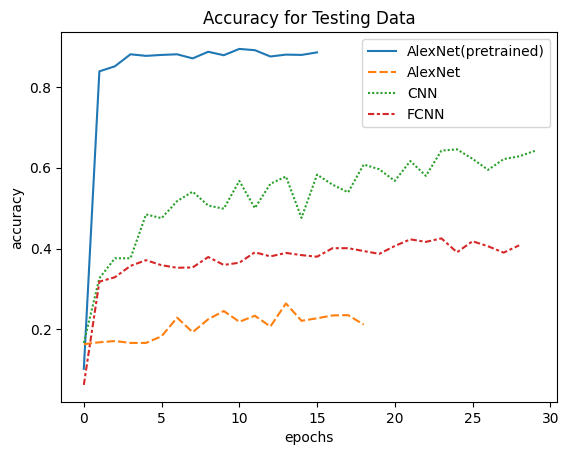

In [ ]:
plot_accuracy({
    "AlexNet(pretrained)": alexnet_pretrained.acc_test,
    "AlexNet": alexnet.acc_test,
    "CNN": cnn.acc_test,
    "FCNN": fcnn.acc_test
}, title="Accuracy for Testing Data")

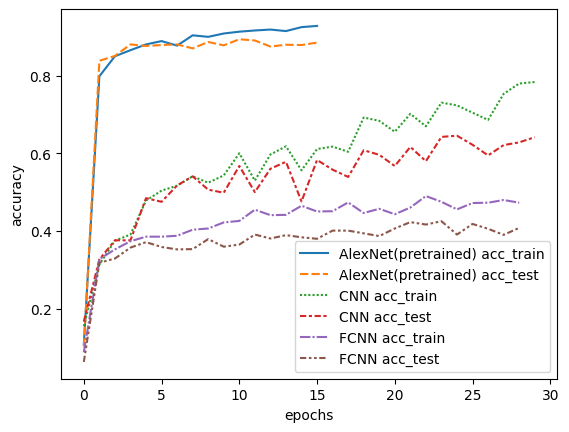

In [ ]:
plot_accuracy({
    "AlexNet(pretrained) acc_train": alexnet_pretrained.acc_train,
    "AlexNet(pretrained) acc_test": alexnet_pretrained.acc_test,
    "CNN acc_train": cnn.acc_train,
    "CNN acc_test": cnn.acc_test,
    "FCNN acc_train": fcnn.acc_train,
    "FCNN acc_test": fcnn.acc_test
})

In [ ]:
alexnet_pretrained.predict(dataloader_test, num_batches=1)

Output hidden; open in https://colab.research.google.com to view.

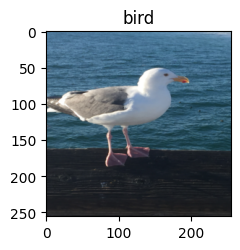

bird      :  99.9%
horse     :   0.1%
dog       :   0.1%



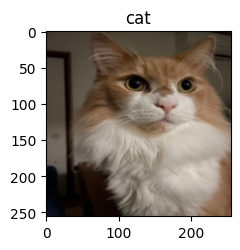

cat       :  99.7%
monkey    :   0.2%
dog       :   0.0%



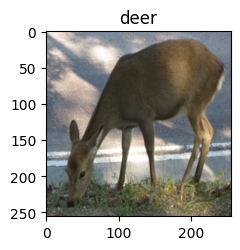

deer      :  89.4%
monkey    :   6.9%
horse     :   2.9%



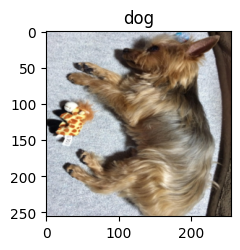

dog       :  66.4%
cat       :  24.4%
monkey    :   4.4%



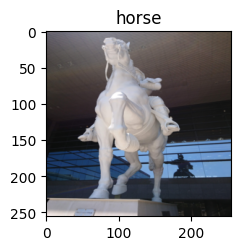

horse     :  94.8%
dog       :   3.9%
deer      :   0.6%

Acc@1 = 100.0% (5/5)
Acc@3 = 100.0% (5/5)


In [ ]:
alexnet_pretrained.predict(dataloader_unknown, num_batches=1)

# Summary

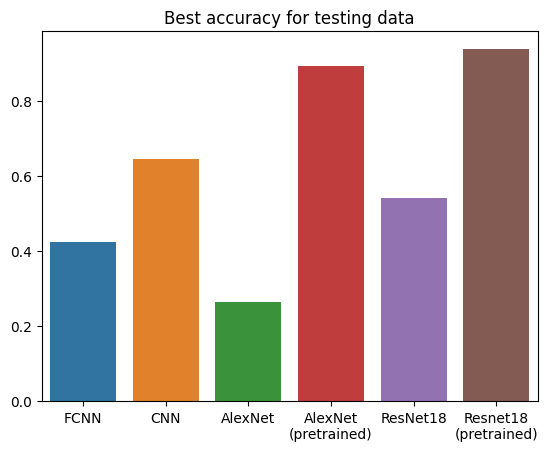

In [ ]:
sns.barplot(pd.DataFrame({
    "FCNN": fcnn.acc_test_best,
    "CNN": cnn.acc_test_best,
    "AlexNet": alexnet.acc_test_best,
    "AlexNet\n(pretrained)": alexnet_pretrained.acc_test_best,
    "ResNet18": resnet18.acc_test_best,
    "Resnet18\n(pretrained)": resnet18_pretrained.acc_test_best,
}, index=['']))
plt.title('Best accuracy for testing data')
plt.show()